In [1]:
#Libraries
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import numpy as np
import os
import cv2
import time
from random import randint
import SimpleITK as sitk
import pandas as pd

#CNN Libraries
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate
from keras.layers.core import Dropout
import tensorflow as tf
# from tensorflow.keras.models import Model
from keras.layers import *
from keras.optimizers import Adam

#Visualisation Libraries
import plotly.graph_objects as go
import pydicom
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Mask Creation Libraries
import trimesh
# import pyvista as pv
from PIL import Image
# from stl import mesh
from skimage import measure
from skimage.transform import resize
from plyfile import PlyData
from pyntcloud import PyntCloud

# Viewer
from scipy import ndimage as ndi
from skimage import (exposure, feature, filters, io, measure,
                      morphology, restoration, segmentation, transform,
                      util)
# import napari 
from matplotlib.widgets import Slider


Height and Width of Single MRI Scan:  (512, 512)


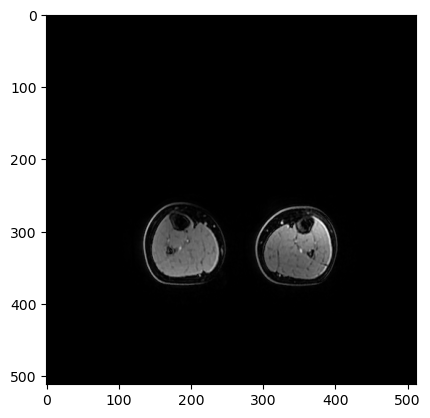

{'X': '-239.53125', 'Y': '-239.53125', 'Z': '-1114.5'}


In [2]:
# Understanding the data format

# Read in Diacom file
example_mri_scan_file = pydicom.dcmread("D:/MRI - Tairawhiti/AutoBindWATER_450/IM-0046-0750.dcm")

# Assessing metadata within Diacom file
example_mri_scan = example_mri_scan_file.pixel_array
example_mri_scan_coordinate_data = example_mri_scan_file.ImagePositionPatient

print('Height and Width of Single MRI Scan: ', example_mri_scan.shape)

plt.imshow(example_mri_scan, cmap='gray')
plt.show()


print({'X': example_mri_scan_coordinate_data[0], 'Y': example_mri_scan_coordinate_data[1], 'Z': example_mri_scan_coordinate_data[2]})

Training Data (MRI Scans) Read-In

In [94]:
def flatten_3d_to_2d(array_3d):
    # Get the dimensions of the 3D array
    depth, height, width = array_3d.shape
    
    # Reshape the 3D array to a 2D array
    array_2d = np.reshape(array_3d, (depth, height * width))
    
    return array_2d

def flatten_2d_array(arr):
    flattened = []
    for row in arr:
        flattened.extend(row)
    return flattened
# Read in entire scan of single patient
# folders = [f for f in os.listdir('MRI Scans - Tairawhiti') if os.path.isdir(os.path.join('MRI Scans - Tairawhiti', f))]
def ListFolders(directory):
    folder_names = []
    for root, dirs, files in os.walk(directory):
        for folder in dirs:
            folder_names.append(folder)
    return folder_names

def read_dicom_files(directory):
    dicom_files = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath) and filename.endswith('.dcm'):
            try:
                dicom_file = pydicom.dcmread(filepath)
                dicom_files.append(dicom_file)
            except pydicom.errors.InvalidDicomError:
                print(f"Skipping file: {filename}. It is not a valid DICOM file.")
    return dicom_files


scans_path = 'D:/MRI - Tairawhiti'
folders = ListFolders(scans_path)

scan_pixel_data = []
scan_coordinate_data = []

# Pixel Data
for paitent in folders:
    single_scan_pixel_data = []
    # single_scan_coord_data = []
    single_paitent_scans_path =  scans_path + '/{}'.format(paitent)
    dicom_files = read_dicom_files(single_paitent_scans_path)
    # D:\MRI - Tairawhiti\AutoBind_WaterWATER_450
    for i in range (len(dicom_files)):
        single_scan_pixel_data.append(dicom_files[i].pixel_array)
        # single_scan_coord_data.append(dicom_files[i].ImagePositionPatient)
    scan_pixel_data.append(single_scan_pixel_data)
    # scan_coordinate_data.append(single_scan_pixel_data)

training_scans = flatten_2d_array(scan_pixel_data)
training_scans = np.array(training_scans)
#TEMP
training_scans = training_scans[0:1015]

# Coordinate Data
for paitent in folders:
    single_paitent_scans_path =  scans_path + '/{}'.format(paitent)
    for i in range (len(dicom_files)):
        scan_coordinate_data.append(dicom_files[i].ImagePositionPatient)
coord_data = pd.DataFrame(scan_coordinate_data, columns=["x", "y", "z"])
coord_data = coord_data[0:1015]
# scan_coordinate_data = flatten_2d_array(scan_coordinate_data)
# scan_coordinate_data = np.array(scan_coordinate_data)

Mapping Coordinate Data from MRI Scans to Mask

In [139]:
# Mapping coordinate data from groundtruth mask/label to mri training data

# Load in mesh of label data
mesh = trimesh.load_mesh('C:/Users/GGPC/OneDrive/Desktop/Part 4 Project/Part4Project/SegmentationMasks/R_tibia_15A.stl')

# Convert the mesh vertices to a DataFrame
vertices = pd.DataFrame(mesh.vertices, columns=["x", "y", "z"])

print('Height of Paitent in mm: ', np.abs(coord_data['z'][1014] - coord_data['z'][0]))
print('Length of Paitent AOI (tibia) in mm: ', np.abs(vertices['z'][0] - vertices['z'][25625]))

vertices['z'] = np.round(vertices['z'] * 2) / 2
coord_data['z'] = np.round(coord_data['z'] * 2) / 2

merged_df = pd.merge(coord_data, vertices, on='z')
condensed_df = merged_df.groupby('z').mean().reset_index()

mapping_dict = dict(zip(condensed_df['z'], ['AOI']*len(condensed_df)))

coord_data['SegmentationRegionSlice'] = coord_data['z'].map(mapping_dict).fillna('Outside of AOI')

slices_aoi_start = (coord_data.loc[coord_data['SegmentationRegionSlice'] == 'AOI'].index)[0]
slices_aoi_end = (coord_data.loc[coord_data['SegmentationRegionSlice'] == 'AOI'].index)[-1]
slice_aoi_range = (slices_aoi_end - slices_aoi_start + 1)
print('AOI Slice Start: ', slices_aoi_start)
print('AOI Slice End: ', slices_aoi_end)
print('AOI Slice Range: ', slice_aoi_range)

# CSV Format 
if False:
    coord_data.to_csv('tibia_mri_coord.csv')

Height of Paitent in mm:  1523.5
Length of Paitent AOI (tibia) in mm:  313.6329999999999
AOI Slice Start:  684
AOI Slice End:  893
AOI Slice Range:  210


Mask (Groundtruth label) 

In [152]:
# Load in mesh of label data
mesh = trimesh.load_mesh('C:/Users/GGPC/OneDrive/Desktop/Part 4 Project/Part4Project/SegmentationMasks/R_tibia_15A.stl')

# Convert the mesh vertices to a DataFrame
vertices = pd.DataFrame(mesh.vertices, columns=["x", "y", "z"])

# Convert the mesh to a PyntCloud object
cloud = PyntCloud(vertices)

# Set the desired resolution
desired_resolution = [slice_aoi_range, 512, 512]

# Voxelize the mesh using the PyntCloud voxelization module
voxelgrid_id = cloud.add_structure("voxelgrid", n_x=desired_resolution[0], n_y=desired_resolution[1], n_z=desired_resolution[2])
voxel_grid = cloud.structures[voxelgrid_id].get_feature_vector().reshape(desired_resolution)

# Transpose and swap axes to change the voxel grid orientation
voxel_grid = np.transpose(voxel_grid, axes=(2, 0, 1))

# Resize the voxel grid to match the desired dimensions
voxel_grid = resize(voxel_grid, desired_resolution, anti_aliasing=False)

voxel_grid = np.where(voxel_grid > 0, 1, 0)

print(voxel_grid.shape)

(210, 512, 512)


Training Scans and Training Label Creation

Visualiser

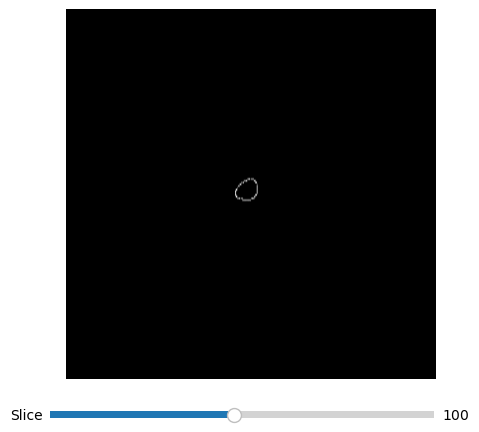

In [151]:
# Visualiser Tool
fig, ax = plt.subplots()
current_slice = 100
# img = ax.imshow(training_scans[current_slice], cmap='gray')
img = ax.imshow(voxel_grid[current_slice], cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, voxel_grid.shape[0] - 1, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(voxel_grid[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

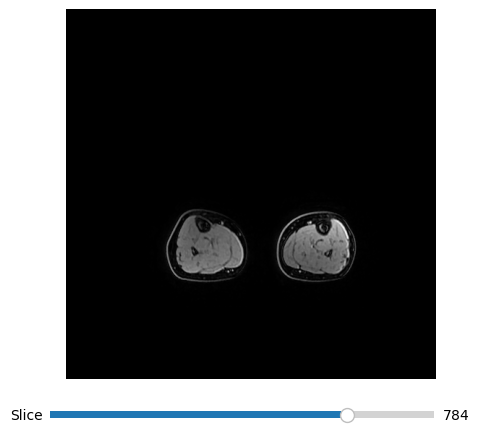

In [149]:
# Visualiser Tool
fig, ax = plt.subplots()
current_slice = 784
# img = ax.imshow(training_scans[current_slice], cmap='gray')
img = ax.imshow(training_scans[current_slice], cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, training_scans.shape[0] - 1, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(training_scans[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

In [32]:
train_single_scan = training_scans[450]
train_single_label = voxel_grid[450]

validation_single_scan = training_scans[451]
validation_single_label = voxel_grid[451]

test_single_scan = training_scans[452]
test_single_label = voxel_grid[452]

In [136]:
# def load_ply_file(file_path):
#     mesh = trimesh.load_mesh(file_path)
#     vertices = np.asarray(mesh.vertices)
#     return vertices

# def preprocess_data(mri_scans, tibia_mask):
#     # Resize MRI scans to match the dimensions of the tibia mask
#     mri_scans_resized = []
#     for scan in mri_scans:
#         resized_scan = resize(scan, tibia_mask.shape[:2], anti_aliasing=True)
#         mri_scans_resized.append(resized_scan)
#     mri_scans_resized = np.array(mri_scans_resized)

#     # Normalize the intensity values of MRI scans to the range [0, 1]
#     mri_scans_normalized = (mri_scans_resized - np.min(mri_scans_resized)) / (np.max(mri_scans_resized) - np.min(mri_scans_resized))

#     # Binarize the tibia mask by setting all non-zero values to 1
#     tibia_mask_binarized = np.where(tibia_mask > 0, 1, 0)

#     return mri_scans_normalized, tibia_mask_binarized


# # tibia_mask = load_ply_file('C:/Users/GGPC/OneDrive/Desktop/Part 4 Project/Part4Project/SegmentationMasks/R_tibia_15A.stl')
# mri_scans_normalized, tibia_mask_binarized = preprocess_data(example_mri_scan, tibia_mask)

Model Architecture

In [38]:
# Define U-Net model
def unet_model(input_shape):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Dice Coefficient Loss Function 
def dice_coefficient(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice


# Set the input shape of your MRI scans
input_shape = (512, 512, 1)

# Load and preprocess your MRI scan dataset and corresponding labels
train_single_scan = training_scans[450]
train_single_label = voxel_grid[450]
train_single_scan = train_single_scan.reshape(-1, 512, 512, 1)
train_single_label = train_single_label.reshape(-1, 512, 512, 1)

validation_single_scan = training_scans[451]
validation_single_label = voxel_grid[451]
validation_single_scan = validation_single_scan.reshape(-1, 512, 512, 1)
validation_single_label = validation_single_label.reshape(-1, 512, 512, 1)


test_single_scan = training_scans[452]
test_single_label = voxel_grid[452]
test_single_scan = test_single_scan.reshape(-1, 512, 512, 1)
test_single_label = test_single_label.reshape(-1, 512, 512, 1)

unseen_single_scan = training_scans[453]
unseen_single_label = voxel_grid[453]
unseen_single_scan = unseen_single_scan.reshape(-1, 512, 512, 1)
unseen_single_label = unseen_single_label.reshape(-1, 512, 512, 1)


# Create an instance of the U-Net model
model = unet_model(input_shape)

# Compile the model
# Binary Cross Entropy Loss Function
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Dice Coefficient Loss Function
# model.compile(optimizer=Adam(), loss=dice_coefficient, metrics=['accuracy'])

# Train the model
model.fit(x=train_single_scan, y=train_single_label, batch_size=16, epochs=5, validation_data=(validation_single_scan, validation_single_label))

# Evaluate the model
loss, accuracy = model.evaluate(x=test_single_scan, y=test_single_label)

# Perform inference on new, unseen MRI scans
predictions = model.predict(unseen_single_scan)

Epoch 1/5
1/1 [==============================] - 23s 23s/step - loss: 11.7728 - accuracy: 0.0128 - val_loss: 2.4051 - val_accuracy: 0.9997
Epoch 2/5
1/1 [==============================] - 17s 17s/step - loss: 1.0632 - accuracy: 0.9999 - val_loss: 0.3473 - val_accuracy: 0.9997
Epoch 3/5
1/1 [==============================] - 17s 17s/step - loss: 0.3089 - accuracy: 0.9999 - val_loss: 0.3465 - val_accuracy: 0.9997
Epoch 4/5
1/1 [==============================] - 18s 18s/step - loss: 0.2841 - accuracy: 0.9999 - val_loss: 0.4112 - val_accuracy: 0.9997
Epoch 5/5
1/1 [==============================] - 4s 4s/step


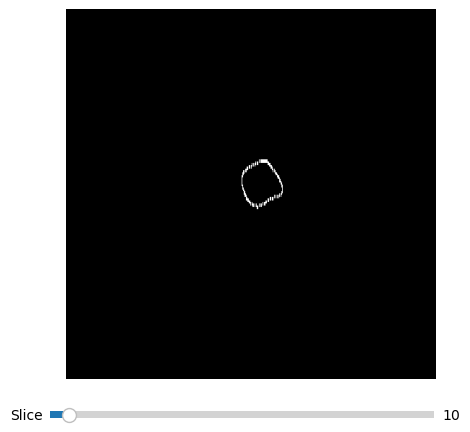

In [137]:
# Visualiser Tool
# voxel_grid_binary, voxel_grid
fig, ax = plt.subplots()
current_slice = 10
# img = ax.imshow(training_scans[current_slice], cmap='gray')
img = ax.imshow(voxel_grid[current_slice], cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, voxel_grid.shape[0] - 1, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(voxel_grid[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

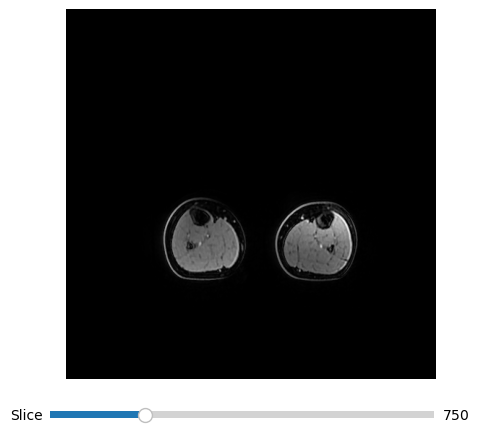

In [121]:
# Visualiser Tool
fig, ax = plt.subplots()
current_slice = 750
# img = ax.imshow(training_scans[current_slice], cmap='gray')
img = ax.imshow(training_scans[current_slice], cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, training_scans.shape[0] - 1, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(training_scans[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

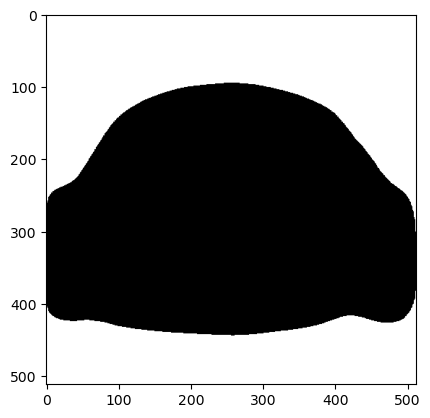

In [39]:
predictions_single_scan = np.reshape(predictions, (512, 512))
predictions_single_scan_binarized = np.where(predictions_single_scan > 0, 1, 0)

plt.imshow(predictions_single_scan_binarized, cmap='gray')
plt.show()

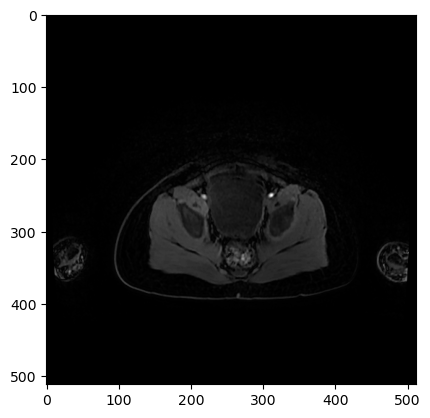

In [77]:
unseen_single_scan_visualise = np.reshape(unseen_single_scan, (512, 512))
# predictions_single_scan_binarized = np.where(predictions_single_scan > 0, 1, 0)

plt.imshow(unseen_single_scan_visualise, cmap='gray')
plt.show()